In [72]:
import os
import pathlib
import random
import tensorflow as tf
import numpy as np
import wave
import pandas as pd
import librosa
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


In [3]:
categories = {i:j for i,j in enumerate(filter(lambda x: x in ['stop', 'up', 'yes', 'down', 'no', 'left', 'right', 'go'],os.listdir(DATASET_PATH)))}
categories

{0: 'up',
 1: 'left',
 2: 'yes',
 3: 'go',
 4: 'right',
 5: 'down',
 6: 'no',
 7: 'stop'}

In [4]:
def load_data(path):
    data = list()
    for idx, folder in categories.items():
        folder_path = os.path.join(path,folder)
        images = os.listdir(folder_path)
        images = [os.path.join(folder_path,image) for image in images]
        for image in images:
            data.append([image,idx])
    return data
data = load_data(DATASET_PATH)

In [5]:
random.shuffle(data)
random.shuffle(data)

In [6]:
def get_sample_rate(d):
    audio_path,label = d
    with wave.open(audio_path, 'rb') as wav_file:
        sample_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()
        duration = num_frames / sample_rate
    return sample_rate,duration,label

audio_info = [get_sample_rate(d) for d in data]
df = pd.DataFrame(audio_info, columns =['sample_rate', 'duration','label'])

In [7]:
df['label'].value_counts()

label
5    1000
3    1000
4    1000
7    1000
0    1000
1    1000
2    1000
6    1000
Name: count, dtype: int64

In [8]:
df.describe()

,sample_rate,duration,label
count,8000.0,8000.000000,8000.000000
mean,16000.0,0.983703,3.500000
std,0.0,0.061426,2.291431
min,16000.0,0.426687,0.000000
25%,16000.0,1.000000,1.750000
50%,16000.0,1.000000,3.500000
75%,16000.0,1.000000,5.250000
max,16000.0,1.000000,7.000000


In [9]:
def compute_mfcc(audio, sample_rate, n_mfcc=13):
    audio = audio.copy()
    audio[np.isnan(audio)] = 0.0
    audio[np.isinf(audio)] = 0.0
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfccs.T

def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def process_audio(audio_path,target_length):
    with wave.open(audio_path, 'rb') as wav_file:
        frames = wav_file.readframes(-1)
        num_channels = wav_file.getnchannels()

        numpy_array = np.frombuffer(frames, dtype=np.float32)
        # numpy_array = np.frombuffer(frames, dtype=np.int16)

        if num_channels == 2:
            numpy_array = numpy_array.reshape(-1, 2)

        if len(numpy_array) < target_length:
            padding_length = target_length - len(numpy_array)
            if num_channels == 2:
                numpy_array = np.pad(numpy_array, ((0, padding_length), (0, 0)), 'constant')
            else:
                numpy_array = np.pad(numpy_array, (0, padding_length), 'constant')

        elif len(numpy_array) > target_length:
            numpy_array = numpy_array[:target_length]

        # mfcc = compute_mfcc(numpy_array,target_length)

        return numpy_array.reshape((target_length,1))

In [10]:
def audio_file_to_spectrogram(audio_path, target_length=16000):

    with wave.open(audio_path, 'rb') as wav_file:
        frames = wav_file.readframes(-1)
        audio_array = np.frombuffer(frames, dtype=np.int16)

        if len(audio_array) < target_length:
            padding_length = target_length - len(audio_array)
            audio_array = np.pad(audio_array, (0, padding_length), 'constant')
        elif len(audio_array) > target_length:
            audio_array = audio_array[:target_length]

        _,_, spectrogram = signal.spectrogram(audio_array, fs=wav_file.getframerate())

        return spectrogram

In [11]:
class DataSequence(tf.keras.utils.Sequence):

    def __init__(self,data,batch_size=32,target_length=44100):
        self.data = data
        self.batch_size = batch_size
        self.target_length = target_length

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self,idx):
        batch = self.data[idx * self.batch_size : (idx + 1) * self.batch_size]
        return self.data_gen(batch)

    def data_gen(self,data):
        audios,labels = list(),list()
        for audio,label in data:
            aud = audio_file_to_spectrogram(audio,self.target_length)
            audios.append(aud)
            labels.append(label)
        return np.array(audios),np.array(labels)

In [12]:
train_ratio = 0.7
val_ratio = 0.1
total_examples = len(data)
train_size = round(total_examples * train_ratio)
val_size = round(total_examples * val_ratio)
train_examples = data[:train_size]
val_examples = data[train_size:train_size+val_size]
test_examples = data[train_size+val_size:]

In [59]:
batch_size = 32
sample_rate = 16000
train_data = DataSequence(train_examples,batch_size,sample_rate)
test_data = DataSequence(test_examples,1,sample_rate)
eval_data = DataSequence(val_examples,batch_size,sample_rate)

In [14]:
input_shape = (*train_data[0][0].shape[1:],1)
input_shape

(129, 71, 1)

In [15]:
# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=list(train_data[1][0].shape[1:])),

#     tf.keras.layers.Conv1D(32,3),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.Conv1D(32,3),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.Conv1D(64,3),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.MaxPooling1D(),
#     tf.keras.layers.Dropout(0.25),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.Dense(128),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.Dense(64),
#     tf.keras.layers.Activation('relu'),
#     tf.keras.layers.Dropout(0.5),

#     tf.keras.layers.Dense(len(categories)),
#     tf.keras.layers.Activation('softmax'),
# ])
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss=tf.keras.losses.sparse_categorical_crossentropy,
#     metrics=['accuracy']
# )


In [16]:
def mobilnet_block(x,filters,strides):
  x = tf.keras.layers.DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  return x

_input = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = mobilnet_block(x, filters = 64, strides = 1)
x = mobilnet_block(x, filters = 128, strides = 2)
x = mobilnet_block(x, filters = 128, strides = 1)
x = mobilnet_block(x, filters = 256, strides = 2)
x = mobilnet_block(x, filters = 256, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 2)
for _ in range (5):
     x = mobilnet_block(x, filters = 512, strides = 1)
x = mobilnet_block(x, filters = 1024, strides = 2)
x = tf.keras.layers.Dropout(0.5)(x)
x = mobilnet_block(x, filters = 1024, strides = 1)
# x = tf.keras.layers.AvgPool2D(pool_size = 7, strides = 1, data_format='channels_first')(x)
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(len(categories), activation = 'softmax', kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(x)
model = tf.keras.Model(inputs=_input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
model.summary()

In [18]:
with tf.device('gpu:0'):
  history = model.fit(train_data,epochs=25,validation_data=eval_data,verbose=1)


Epoch 1/25
175/175 [==============================] - 35s 76ms/step - loss: 2.9107 - accuracy: 0.1843 - val_loss: 2.7003 - val_accuracy: 0.1200
Epoch 2/25
175/175 [==============================] - 11s 64ms/step - loss: 2.1688 - accuracy: 0.3154 - val_loss: 3.0680 - val_accuracy: 0.1275
Epoch 3/25
175/175 [==============================] - 9s 51ms/step - loss: 1.7127 - accuracy: 0.4461 - val_loss: 3.0136 - val_accuracy: 0.1200
Epoch 4/25
175/175 [==============================] - 9s 52ms/step - loss: 1.2930 - accuracy: 0.5752 - val_loss: 3.2235 - val_accuracy: 0.1775
Epoch 5/25
175/175 [==============================] - 9s 49ms/step - loss: 0.9610 - accuracy: 0.6970 - val_loss: 4.9321 - val_accuracy: 0.2375
Epoch 6/25
175/175 [==============================] - 8s 48ms/step - loss: 0.7367 - accuracy: 0.7677 - val_loss: 2.0216 - val_accuracy: 0.3950
Epoch 7/25
175/175 [==============================] - 8s 46ms/step - loss: 0.6118 - accuracy: 0.8084 - val_loss: 3.2104 - val_accuracy: 0.26

In [65]:
y_true = [i[0] for _,i in test_data]
y_pred = [np.argmax(i) for i in model.predict(test_data)]

1600/1600 [==============================] - 6s 4ms/step


In [66]:
conf_mat = tf.math.confusion_matrix(y_true,y_pred)

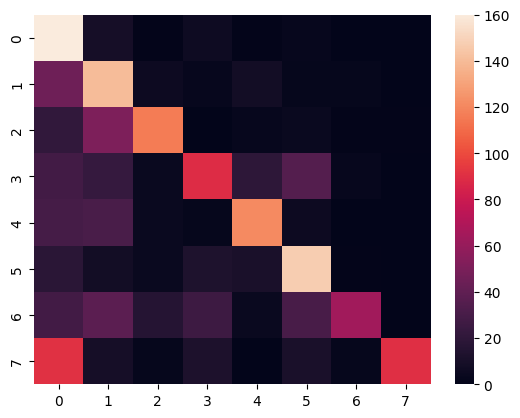

In [21]:
sns.heatmap(conf_mat)
plt.show()

In [74]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.38      0.89      0.53       180
           1       0.45      0.68      0.54       205
           2       0.76      0.59      0.66       197
           3       0.59      0.44      0.51       201
           4       0.72      0.63      0.67       192
           5       0.62      0.73      0.67       202
           6       0.88      0.31      0.46       206
           7       0.99      0.41      0.58       217

    accuracy                           0.58      1600
   macro avg       0.67      0.59      0.58      1600
weighted avg       0.68      0.58      0.58      1600



In [23]:
model.save('classifier.keras')
from google.colab import files
files.download('classifier.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [77]:
with open("converted_model.tflite", "wb") as f:
  f.write(tflite_model)

files.download('converted_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [79]:
output_details = interpreter.get_output_details()[0]
input_details = interpreter.get_input_details()[0]

In [80]:
input_details['shape']

array([  1, 129,  71,   1], dtype=int32)

In [81]:
y_pred_lite = list()
for ar,_ in test_data:
    input_data = ar.reshape(input_details['shape'])
    interpreter.set_tensor(input_details['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details['index'])
    y_pred_lite.append(np.argmax(output_data))

In [82]:
conf_mat_lite = tf.math.confusion_matrix(y_true,y_pred_lite)

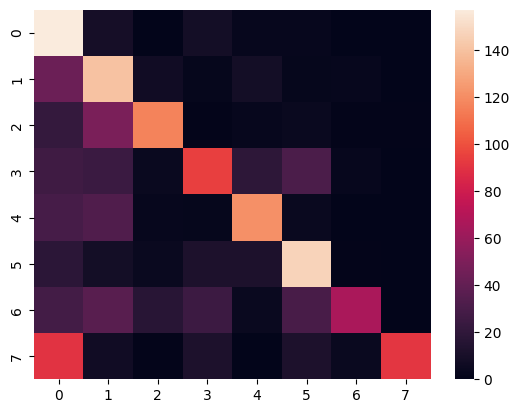

In [83]:
sns.heatmap(conf_mat_lite)
plt.show()

In [84]:
print(classification_report(y_true,y_pred_lite))

              precision    recall  f1-score   support

           0       0.38      0.87      0.53       180
           1       0.46      0.68      0.55       205
           2       0.76      0.59      0.66       197
           3       0.60      0.47      0.53       201
           4       0.71      0.63      0.67       192
           5       0.63      0.73      0.68       202
           6       0.85      0.32      0.46       206
           7       0.99      0.42      0.59       217

    accuracy                           0.58      1600
   macro avg       0.67      0.59      0.58      1600
weighted avg       0.68      0.58      0.58      1600



In [87]:
print("Float model in Mb:", os.path.getsize('classifier.keras') / float(2**20))
print("Quantized model in Mb:", os.path.getsize('converted_model.tflite') / float(2**20))


Float model in Mb: 38.66401195526123
Quantized model in Mb: 3.34521484375
